终于有个能用的模型了...

Todo:
- 改进ROC
- 尝试每个epoch随机载入数据
- 尝试正则化 https://cloud.tencent.com/developer/ask/149180
- 特征工程 https://zhuanlan.zhihu.com/p/37880492
- weight scale
- 考虑样本不平衡 https://zhuanlan.zhihu.com/p/56882616

In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import sys
sys.path.append("..")
import autoaim

# Devices
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Device: GPU.')
else:
    device = torch.device('cpu')
    print('Device: CPU.')

#device = torch.device('cpu')

# Dataset
def preprocess(t,h):
    # shuffling
    r = torch.randperm(t.size(0))
    t = t[r,:]
    # GIVE ME MORE!!
    _ = t[:,:-1]
    t = torch.cat((_,t[:,-1:]),1)
    return t

def load(filename):
    header, data = autoaim.helpers.read_csv(filename)
    data = torch.Tensor(data).to(device)
    data = preprocess(data,header)
    x = data[:, :-1]
    y = data[:, -1:]
    return x, y, header

x_train, y_train, header = load('test_pair_train.csv')
x_test, y_test, _ = load('test_pair_test.csv')

train_dataset_size = x_train.size(0)
test_dataset_size = x_test.size(0)
input_size = x_train.size(1)
output_size = 3

print('====== Input ======')
print('train_dataset_size: {}'.format(train_dataset_size))
print('test_dataset_size: {}'.format(test_dataset_size))
print('input_size: {}'.format(input_size))

# Model
class Model(torch.nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
#         y_pred = self.sigmoid(self.linear(x))
        y_pred = self.linear(x)
        return y_pred

# Training loop
@autoaim.helpers.time_this
def train(learning_rate, epoch_num):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    # Train loop
    print('====== Config ======')
    print('learning_rate: {}'.format(learning_rate))
    print('epoch_num: {}'.format(epoch_num))
    loss_list = []
    for epoch in range(epoch_num):
        # Forward pass
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train.t().squeeze().long())

        # Backward and optimize 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch == 0 or (epoch+1) % (epoch_num/10) == 0:
            y_pred = model(x_test)
            loss_test = criterion(y_pred, y_test.t().squeeze().long())
            print("Epoch: [{!s:6}/{!s:6}], Loss: {:.2f}, Test loss: {:.2f}"
                  .format(epoch+1, epoch_num, loss,loss_test))

        if epoch == 0 or (epoch+1) % (epoch_num/1000) == 0:
            y_pred = model(x_test)
            loss_test = criterion(y_pred, y_test.t().squeeze().long())
            loss_list += [loss_test]
    
    x = np.arange(0, len(loss_list), dtype=int)
    plt.plot(x, np.array(loss_list), 'ro',label='loss')
    plt.legend()
    plt.show()

Device: CPU.
====== Input ======
train_dataset_size: 915
test_dataset_size: 224
input_size: 8
decorating


starting timer
====== Config ======
learning_rate: 0.01
epoch_num: 50000
Epoch: [1     /50000 ], Loss: 1.72, Test loss: 1.66
Epoch: [5000  /50000 ], Loss: 0.31, Test loss: 0.38
Epoch: [10000 /50000 ], Loss: 0.29, Test loss: 0.37
Epoch: [15000 /50000 ], Loss: 0.28, Test loss: 0.36
Epoch: [20000 /50000 ], Loss: 0.27, Test loss: 0.35
Epoch: [25000 /50000 ], Loss: 0.26, Test loss: 0.34
Epoch: [30000 /50000 ], Loss: 0.26, Test loss: 0.34
Epoch: [35000 /50000 ], Loss: 0.25, Test loss: 0.33
Epoch: [40000 /50000 ], Loss: 0.25, Test loss: 0.33
Epoch: [45000 /50000 ], Loss: 0.24, Test loss: 0.32
Epoch: [50000 /50000 ], Loss: 0.24, Test loss: 0.32


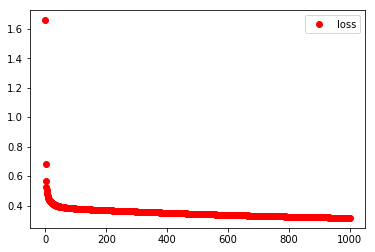

Elapsed Time = 0:00:32.463106


In [6]:
model = Model().to(device)
# train(0.00003, 100000)
train(0.01, 50000)


Data Distribution


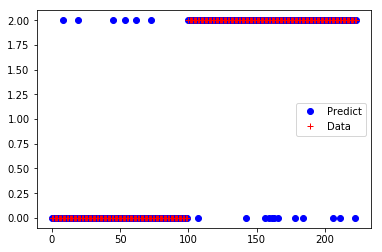

ROC
true positive: 0
false positive: 6
true negative: 94
false negative: 0

Weight


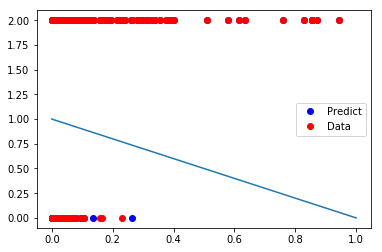

w[0] bounding_rect.y_diff #1: -3.1079204082489014


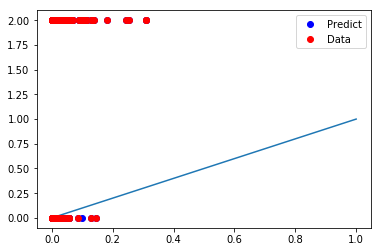

w[1] bounding_rect.width_diff #1: 0.12459117919206619


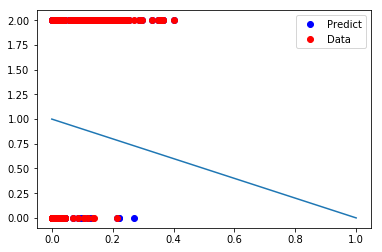

w[2] bounding_rect.height_diff #1: -3.5222878456115723


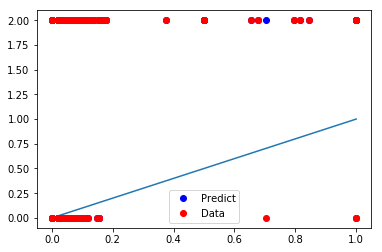

w[3] rotated_rect.rotated_angle_left #1: 0.46821582317352295


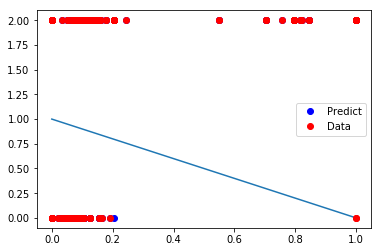

w[4] rotated_rect.rotated_angle_right #1: -0.6359010934829712


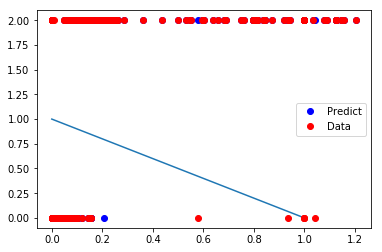

w[5] rotated_rect.rotated_angle_diff #1: -1.5666272640228271


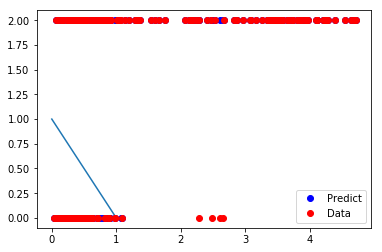

w[6] contour_feature.ratio_small #1: -0.014870301820337772


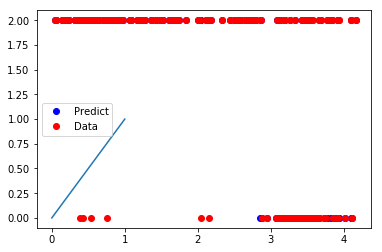

w[7] contour_feature.ratio_large #1: 1.2205190658569336


In [7]:
# Test
def analyse(x_anls, y_anls, threshold):
    # Predict
    y_pred = model(x_anls)
    _,y_pred = torch.max(y_pred,1)
    y_pred = y_pred.reshape((y_pred.size(0),1))

    # Convert to numpy array
    x_anls, y_anls, y_pred = (t.numpy() for t in [x_anls, y_anls, y_pred])

    # Sort
    _1,_2,_3 = np.where(y_anls==2)[0],np.where(y_anls==1)[0],np.where(y_anls==0)[0]
    x_anls, y_anls, y_pred = [np.concatenate((t[_3,:],t[_2,:],t[_1,:])) for t in (x_anls, y_anls, y_pred)]

    # Distribution
    print('Data Distribution')
    x = np.arange(0, x_anls.shape[0], dtype=int)
    # x_anls = np.arange(0, 40, dtype=int)
    plt.plot(x, y_pred[x,:], 'bo', label='Predict')
    plt.plot(x, y_anls[x,:], 'r+', label='Data')
    plt.legend()
    plt.show()

    # ROC
    print('ROC')
    num_positive = len(np.where(y_anls==1)[0])
    num_negative = len(np.where(y_anls==0)[0])
    _ = np.where(y_pred>=threshold)[0]
    num_true_positive = len(np.where(y_anls[_,:]==1)[0])
    num_false_positive = len(np.where(y_anls[_,:]==0)[0])
    _ = np.where(y_pred<threshold)[0]
    num_false_negative = len(np.where(y_anls[_,:]==1)[0])
    num_true_negative = len(np.where(y_anls[_,:]==0)[0])
    print('true positive: {}'.format(num_true_positive))
    print('false positive: {}'.format(num_false_positive))
    print('true negative: {}'.format(num_true_negative))
    print('false negative: {}\n'.format(num_false_negative))

    # Weight
    x = np.linspace(0,1)
    w = [wi.data.cpu() for wi in model.parameters()]
    w = torch.cat((w[0][0],w[1])).numpy()
    print('Weight')
    b = w[-1]
    for i in range(input_size):
        a = w[i]
        y = a*x+b
        plt.plot(x, (y-y.min())/(y.max()-y.min()), linestyle='-')
        plt.plot(x_anls[:, i], y_pred, 'bo', label='Predict')
        plt.plot(x_anls[:, i], y_anls, 'ro', label='Data')
        plt.legend()
        plt.show()
        _1, _2 = i%(len(header) - 1), int((i+1)/len(header)+1)
        print('w[{}] {} #{}: {}'.format(i, header[_1], _2, w[i]))
# Save     
def save(filename):
    dataloader = autoaim.DataLoader()
    autoaim.helpers.new_csv(filename, header[:-1])
    w = [wi.data.cpu() for wi in model.parameters()]
    w = torch.cat((w[0], w[1].reshape(3,1)),1)
    w = w.reshape(1,w.size(0)*w.size(1)).numpy()
    for row in w:
        autoaim.helpers.append_csv(filename, row)

with torch.no_grad():
#     x_test, y_test,*_ = load('test.csv', 0)
    save('pair.csv')
    analyse(x_test, y_test, 0.5)
    

In [5]:
_, w_pair = autoaim.helpers.read_csv('pair.csv')
w_pair = np.array(w_pair).reshape(3, 9)
np.argmax(w_pair,1)

array([4, 8, 0], dtype=int64)

In [147]:
w = [wi.data.cpu() for wi in model.parameters()]
w

[tensor([[11.4781,  0.1718,  5.9541,  0.5898,  1.2185,  1.2339,  2.5104],
         [-6.7533, -0.4225, -3.1921, -1.0096, -2.8573,  0.2231, -1.5092],
         [-4.2981,  0.1669, -2.0975,  0.5778,  1.0222, -1.4349, -0.8632]]),
 tensor([-3.3779,  5.0058, -1.8040])]

In [157]:
x = [0.0,0.01,0.01,5.7368421052631575,0.0,0.0,0.0]

In [158]:
model(torch.tensor(x))

tensor([ 0.0667, -0.8221,  1.4916], grad_fn=<AddBackward0>)

In [164]:
xx = np.array([0.0,0.01,0.01,5.7368421052631575,0.0,0.0,0.0,1])

In [165]:
ww = np.array([[11.478054,-6.753303,-4.2981124 ],
 [ 0.17179687,-0.4225374,0.1669333 ],
 [ 5.9541306,-3.192075,-2.0974908 ],
 [ 0.5897511,-1.00957,0.5778351 ],
 [ 1.2184564,-2.8572545,1.0222359 ],
 [ 1.2338663,0.2230821,-1.4348943 ],
 [ 2.510402,-1.5092028,-0.863153],
 [-3.3778744,5.005751,-1.8040271 ]])

In [166]:
xx.dot(ww)

array([ 0.06669382, -0.82213881,  1.49161606])